This is a walkthrough of time series forcasting with xgboost. I've thrown in a lot of my own work for some advanced demonstrations (more robust Cross Validation and additional features). My notebook is more step-by-step, but the original inspiration for the basic tutorial must be credited to Rob Mulla. 

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()                                      
plt.style.use('fivethirtyeight') #has gridlines on the plot area with bold x and y ticks

#for more on customisations:
#https://www.analyticsvidhya.com/blog/2021/08/exploring-matplotlib-stylesheets-for-data-visualization/

In [211]:
#from exploring the head and tail we see that the data goes from 2002 to 2018
PJME = pd.read_csv("PJME_hourly.csv\PJME_hourly.csv")
PJME.head() 

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [212]:
#reset index to the datetime column
PJME = PJME.set_index('Datetime')
PJME

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [213]:
#check data type of column
PJME.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [214]:
#cast to date time 
PJME.index = pd.to_datetime(PJME.index)
PJME

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [215]:
PJME.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

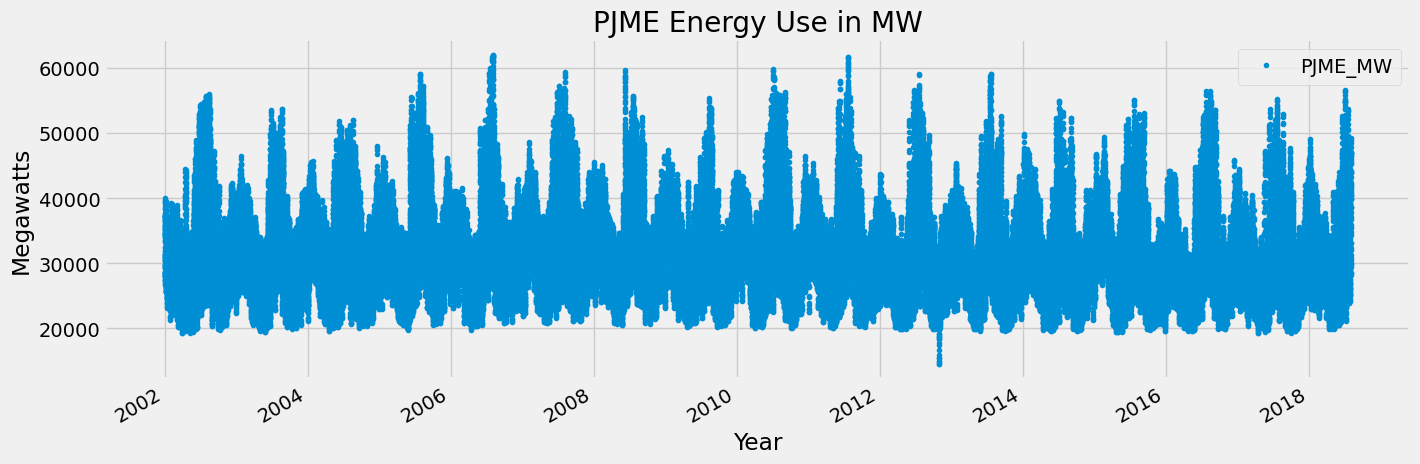

In [216]:
#formatting as date time makes our plot look better as well!
ax = PJME.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0], #just using first colour in our colour pallete defined in first cell
        title='PJME Energy Use in MW')
ax.set_xlabel("Year")
ax.set_ylabel("Megawatts")
plt.show()

## Train Test Split

In [217]:
#Come back and do full cross validation
#for demo purposes splitting on date january 2015 (after is test data)

train = PJME.loc[PJME.index < "01-01-2015"]
test = PJME.loc[PJME.index >= "01-01-2015"]

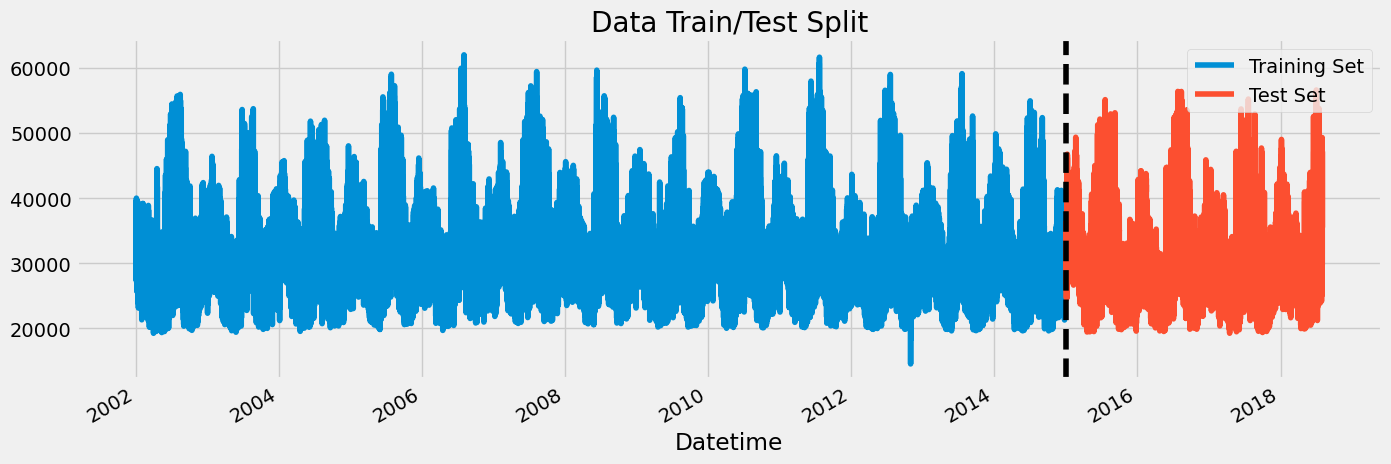

In [218]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title='Data Train/Test Split')
test.plot(ax=ax, label="Test Set")
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

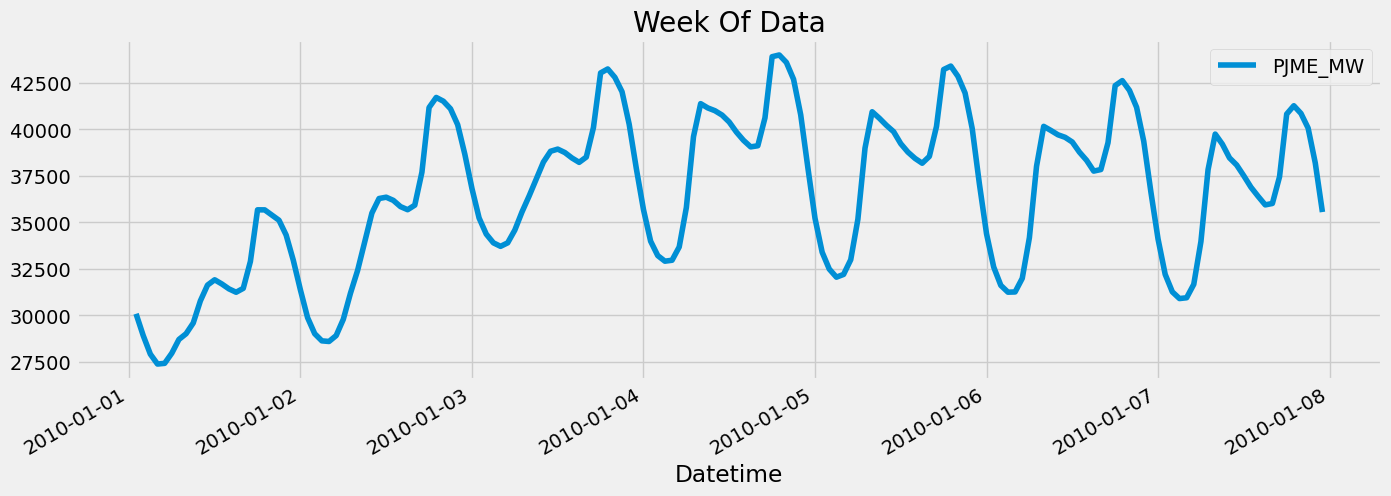

In [219]:
#get an idea of what one week of data looks like
PJME.loc[(PJME.index > "01-01-2010") & (PJME.index < "01-08-2010")] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

It looks like there are two peaks in energy consumption during the day. We have a valley at night. It looks like we may have a weekend effect here, but one should note that January 1st would be a holiday. Weekend vs weekday and holidays have effects that we can explore. 

## Feature Creation

In [220]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week       #monday=0, sunday=6
    df["quarter"] = df.index.quarter             #split the year into 4 groups
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df

In [221]:
PJME = create_features(PJME)

In [222]:
PJME.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


## Visualise our Feature/Target Relationship

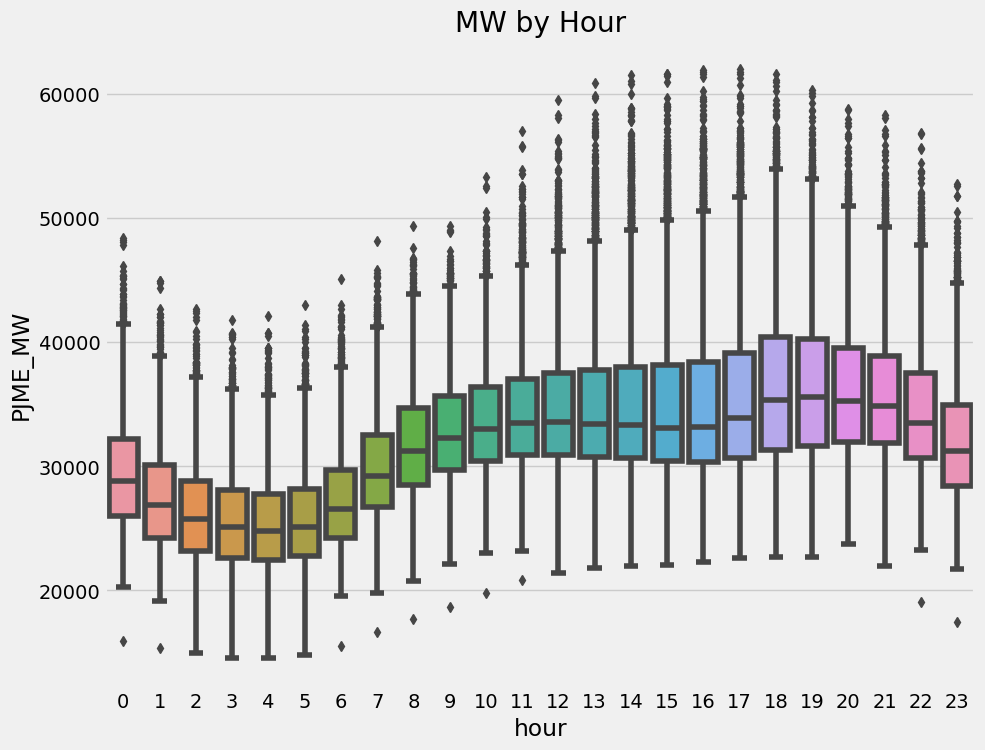

In [223]:
#use boxplot to get an idea of the distribution of the dataset
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=PJME, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

Early in the morning, there seems to be a dip in energy use, tends to get higher later in the evening. 

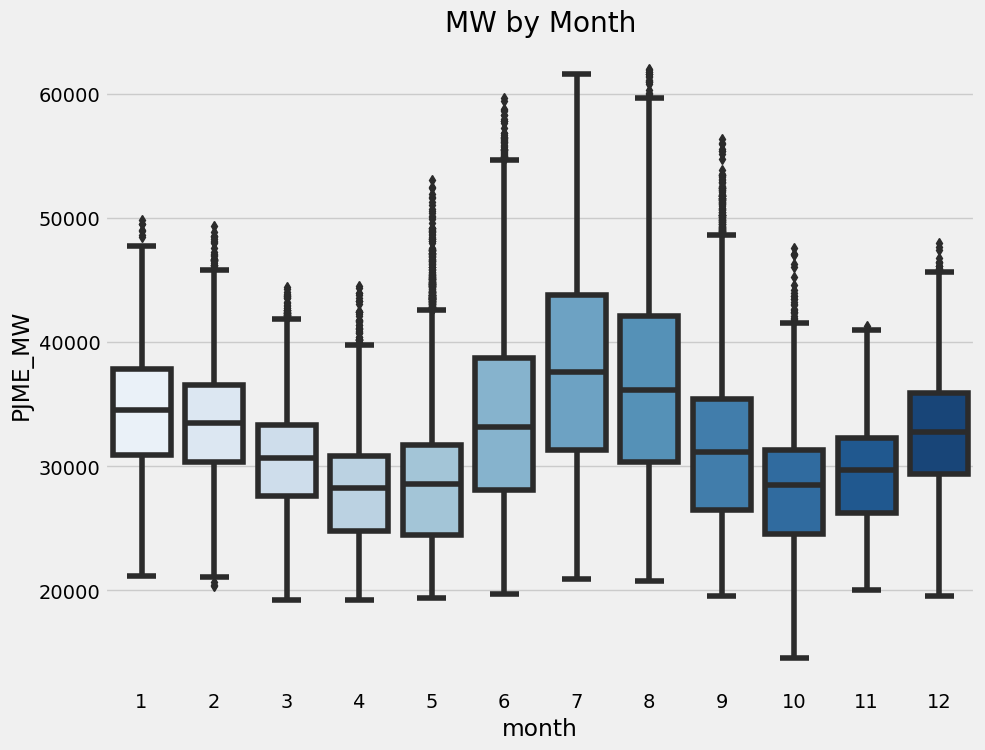

In [224]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=PJME, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

Peaks in Winter season and Summer. 

## Create our Model

We will use mean squared error here which will give a larger penalty for any predictions that are way off but the type of metric chosen depends one what you are trying to do with the data set.  

In [225]:
PJME.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [226]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [227]:
#create a regression model, tune n_estimators, fit model

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,                #boosted tree algorithm will create 1000 trees
                       early_stopping_rounds=50,         #stops model training when overfitting occurs
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)               #prevents overfitting
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100) #print out training and validation score every 100 tree built

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\mykal\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:01:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

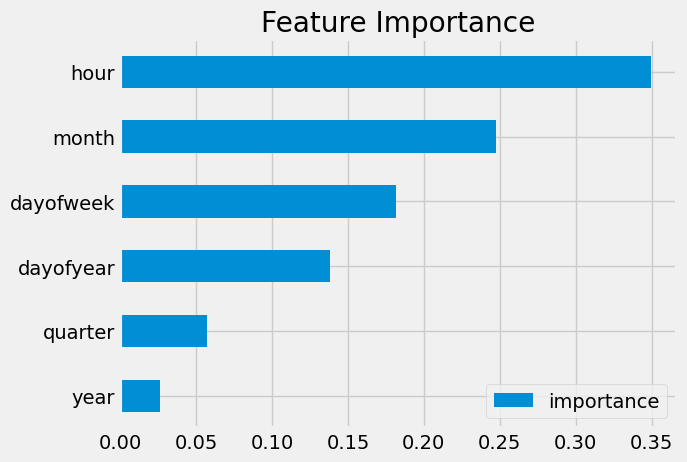

In [228]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

When we have highly correleted features, like we have here, feature importances will not really tell you exactly how important each feature individually so much as it tells you as a collective in this complete model. There are other packages available for exploring feature importances, but this gives us a good idea of what our model is using. 

## Forcast on Test with Trained Model

In [229]:
test["prediction"] = reg.predict(X_test)

In [230]:
#Let's take a look at these next to all of the training data
#merge data frames on the idex columns
PJME_merged = PJME.merge(test[['prediction']], how="left", left_index=True, right_index=True)
PJME_merged

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42575.265625
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42522.703125
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40804.101562


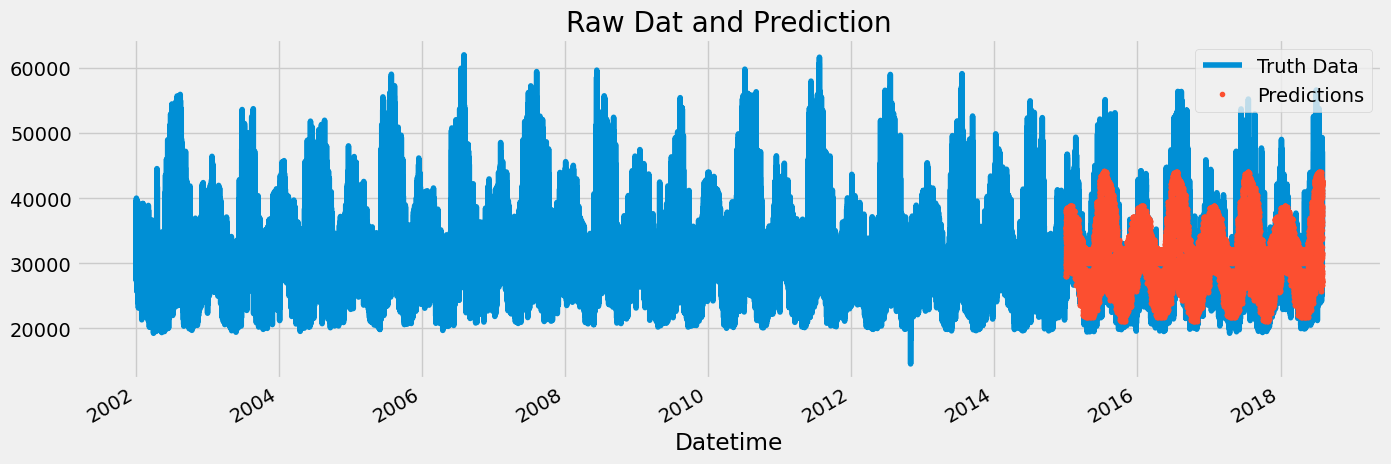

In [231]:
ax = PJME_merged[['PJME_MW']].plot(figsize=(15, 5))
PJME_merged['prediction'].plot(ax=ax, style='.')   #plot predictions overlayed on data
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

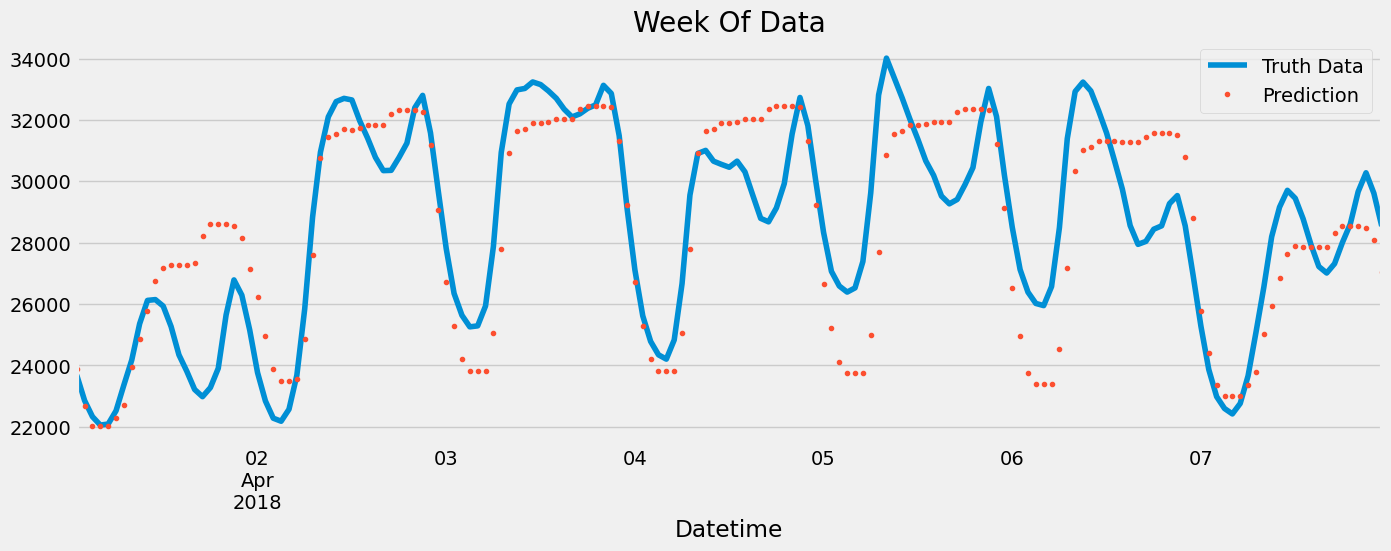

In [232]:
#one week of predictions
ax = PJME_merged.loc[(PJME_merged.index > '04-01-2018') & (PJME_merged.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
PJME_merged.loc[(PJME_merged.index > '04-01-2018') & (PJME_merged.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Few things we can do to improve this: better parameter tuning, add in features for specific days of the year like holidays. Overall, trend is captured by this model though. 

## Score (RMSE)

In [233]:
#run evaluation metric
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


We would like to reduce this score to improve the model

## Calculate Error

In [234]:
#look at worst and best predicted days
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
days_prediction_rating = test.groupby(['date'])['error'].mean().reset_index()
top_10_worst_days = days_prediction_rating.sort_values(by='error', ascending=False).head(10)
top_10_worst_days

,date,error
590,2016-08-13,12879.484619
591,2016-08-14,12772.887207
50,2015-02-20,11186.031494
617,2016-09-09,10966.513102
618,2016-09-10,10889.102214
1101,2018-01-06,10642.975830
589,2016-08-12,10041.172689
51,2015-02-21,9988.168783
46,2015-02-16,9900.809326
1102,2018-01-07,9852.571370


In [235]:
top_10_best_days = days_prediction_rating.sort_values(by='error', ascending=True).head(10)
top_10_best_days

,date,error
1027,2017-10-24,322.958008
300,2015-10-28,426.451335
665,2016-10-27,543.167155
125,2015-05-06,556.749674
1018,2017-10-15,569.468262
1231,2018-05-16,569.951009
309,2015-11-06,678.310140
827,2017-04-07,687.475911
728,2016-12-29,706.143392
624,2016-09-16,711.019694


## Next Steps
- outlier analysis and removal
- More Robust Cross validation
- Add more features (weather forecast from external source, holidays)

## Outlier Removal

We can see in our fisrt figure above that there is an issue in the year 2012 (very low numbers). This could be due to outages or issue with sensors, for example. We do not want our model to train on this data. 

<Axes: ylabel='Frequency'>

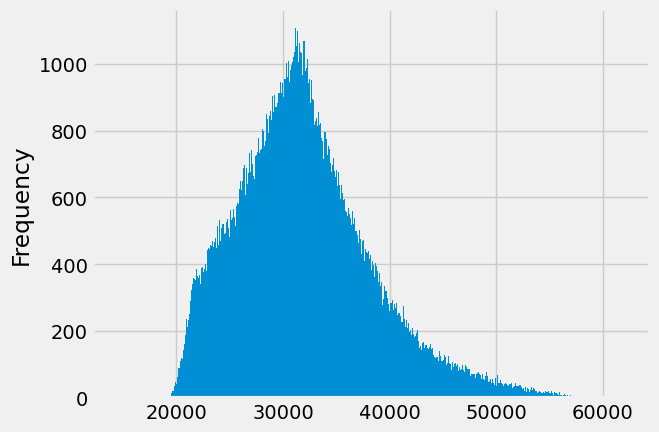

In [236]:
#look at histogram of values
PJME['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

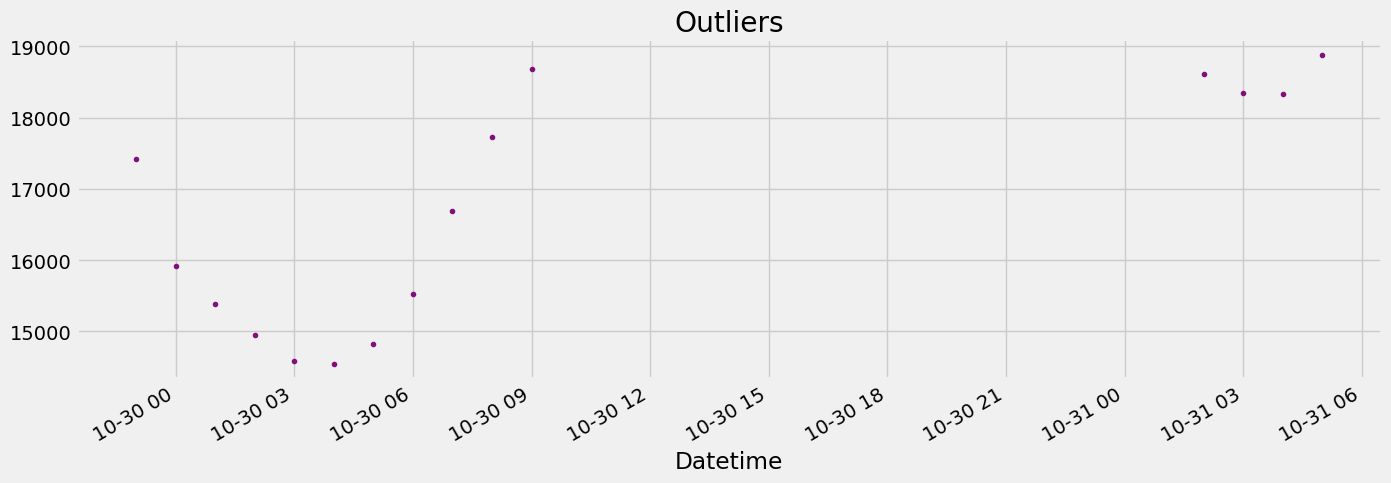

In [237]:
#query on values less than 19,000
PJME.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

We could also look at the standard deviation/number of outliers that way, but visually inspecting can be better than a heuristic approach. 

In [238]:
PJME_filtered = PJME.query("PJME_MW > 19_000").copy()

## Time Series Cross Validation

- https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split
- allows us to tell it the max training size, the number of splits, and then it creates those splits for us

In [239]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #24 hours * 365 days * 1 year, gap=24 hours btwn training/test
PJME_filtered = PJME_filtered.sort_index() #if not sorted, this tss will not work
PJME_filtered

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31


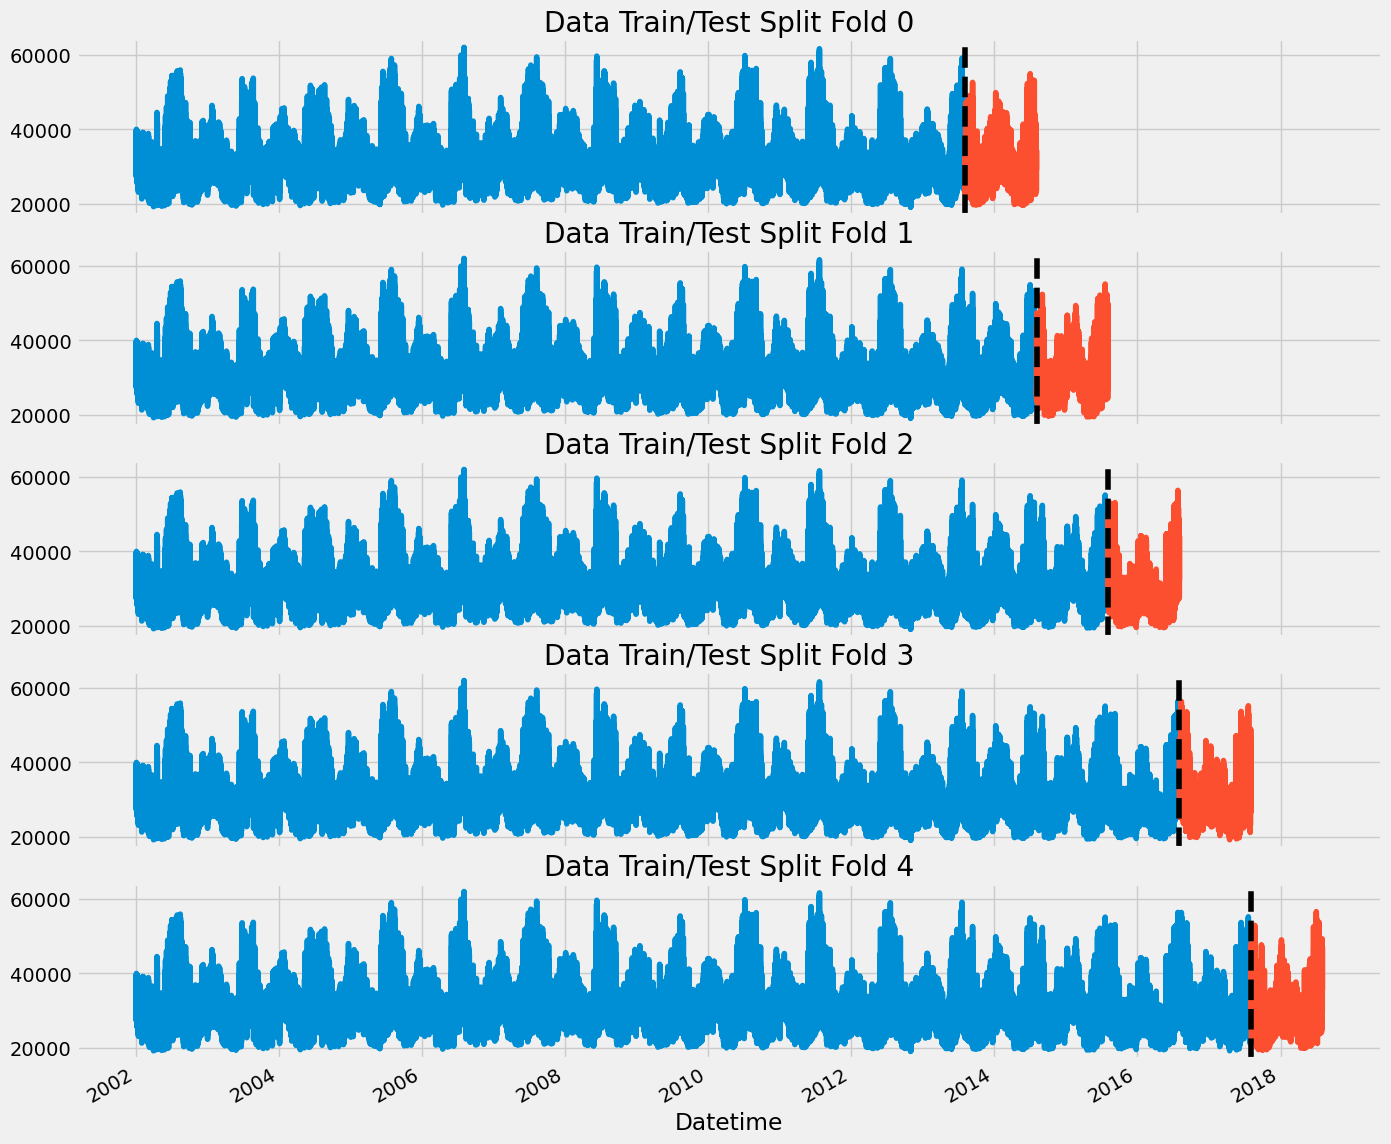

In [240]:
#make a subplot for each of the splits, put on same x-axis
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0      #track number of folds

#to run on the tss generator you loop over it and apply it to the training data set
for train_idx, val_idx in tss.split(PJME_filtered):
    train = PJME_filtered.iloc[train_idx]
    test = PJME_filtered.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

We have one year of our validation set in each fold. We train 5 different time, and test each of the last 5 years independent of eachother. If we didn't do this and take out data from the years after our test data, we would get a leak about our target into our validation data!

## Forcasting Horizon and Lag Features
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).
The further out you want to predict, typically the less accuracy you will have. 

- We have already added our time series features with our create features function
- Lag features: tell the model to look back into the model x number of days in the past and use the target value for that many days in the past as a new feature that you feed into the model
- With Lag features we can't add back further than the time horizon

In [241]:
#We are going to make a dictionary from our target values and then map our lag features onto our df

def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) #divisible by 7 (gets you same day of week)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [242]:
PJME_lags = add_lags(PJME_filtered)

In [246]:
PJME_lags.tail() #you will see nulls in head because those values are too far back

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


Important to note that we are restricted by lag1, so we can't look further out than one year

## Train using Cross Validation

In [248]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
PJME_lags = PJME_lags.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(PJME_lags):
    train = PJME_lags.iloc[train_idx]
    test = PJME_lags.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


C:\Users\mykal\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


C:\Users\mykal\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:06:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


C:\Users\mykal\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[411]	validation_0-rmse:3475.26636	validation_1-rmse:3503.65414
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


C:\Users\mykal\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


C:\Users\mykal\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[439]	validation_0-rmse:3480.87364	validation_1-rmse:4011.68406


In [250]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


## Predicting Future Values

- Retrain on all data
- Make an emtpy dataframe for future date ranges.
- Run those dates through feature creation code + lag creation


In [252]:
# Retrain on all data
df = create_features(PJME_lags)
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = PJME_lags[FEATURES]
y_all = PJME_lags[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


C:\Users\mykal\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [264]:
df.index.max() #make this value the first date of our future dataframe

Timestamp('2018-08-03 00:00:00')

In [254]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h') #predict hourly
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [255]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [256]:
future_w_features = df_and_future.query('isFuture').copy()

In [257]:
#predict the future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

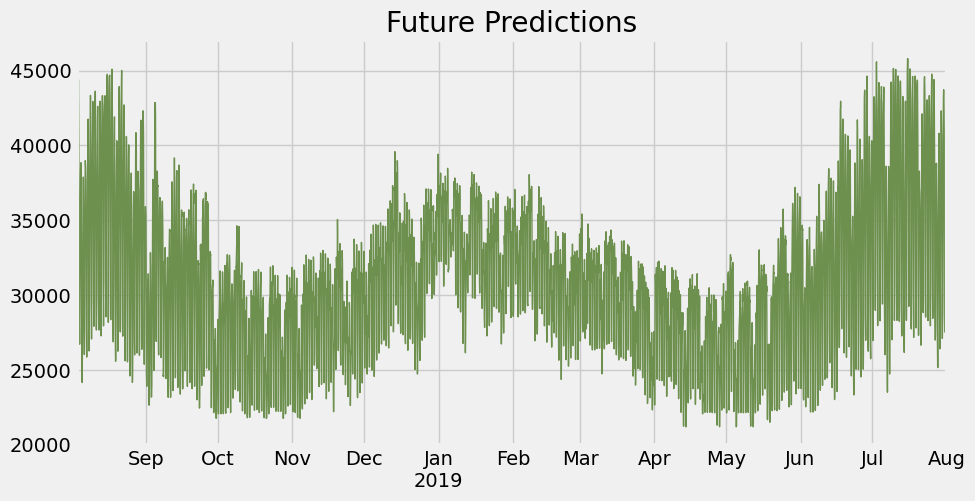

In [259]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

## Saving the model for later

In [260]:
# Save model
reg.save_model('model.json')

<Axes: title={'center': 'Future Predictions'}>

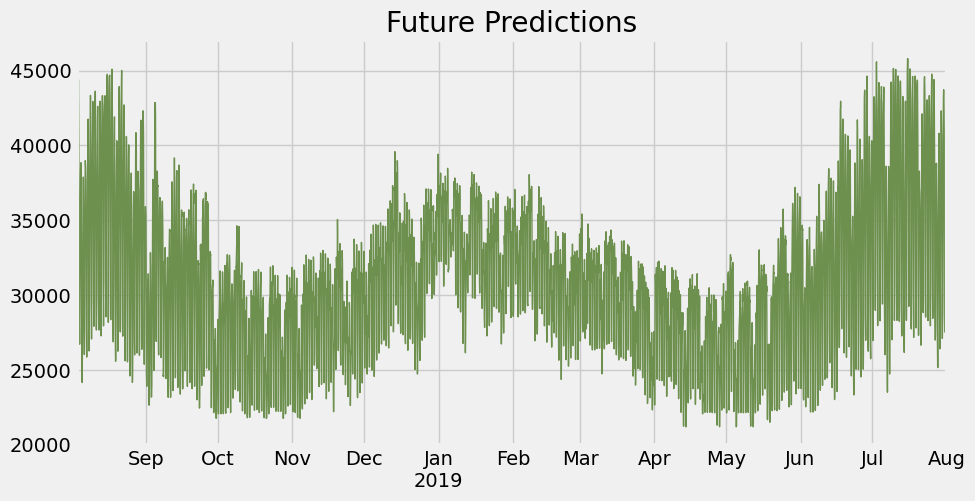

In [263]:
#demonstrating loading back in
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1, lw=1,
                               title='Future Predictions')